In [3]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 150)

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
Submission = pd.read_csv("sampleSubmission.csv")

In [5]:
train_x = train.drop("revenue",axis=1)
train_y = pd.DataFrame(train["revenue"])

In [6]:
print(train_x.shape)
print(test.shape)

(137, 42)
(100000, 42)


In [7]:
data = pd.concat([train_x,test])
print(data.shape)
print(data.isnull().sum().sum())

(100137, 42)
0


In [8]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [9]:
def feature_engineer(df):
    df = df.astype(float,errors="ignore")
    df["Open Date"] = pd.to_datetime(df["Open Date"], format='%m/%d/%Y')
    df = df.set_index("Open Date")
    df["Open_Year"] = df.index.year
    df["Open_Month"] = df.index.month
    df = df.reset_index(drop=True)
    df = create_dummies(df,"Type")
    df = create_dummies(df,"City Group")
    df = create_dummies(df,"City")
    df = create_dummies(df,"Open_Year")
    df = create_dummies(df,"Open_Month")
    df = df.drop(["City","City Group","Type","Open_Year","Open_Month"],axis=1)
    return df

In [10]:
data_rf = feature_engineer(data)

In [11]:
train_rf_x = data_rf[:137]
test_x = data_rf[137:]
print(train_rf_x.shape)
print(test_x.shape)

(137, 139)
(100000, 139)


In [12]:
train_rf_x = train_rf_x.drop("Id",axis=1)
Submission_id = pd.DataFrame(test_x["Id"]).astype(int).reset_index(drop=True)
test_rf_x = test_x.drop("Id",axis=1).reset_index(drop=True)

In [13]:
print(train_rf_x.shape) # Performed features normalization
print(train_y.shape)
print(test_rf_x.shape) # Performed features normalization
print(Submission_id.shape)

(137, 138)
(137, 1)
(100000, 138)
(100000, 1)


In [14]:
# Transform features only, and need no inverse_transform back
from sklearn.preprocessing import StandardScaler
train_score_scaler = StandardScaler()
test_score_scaler = StandardScaler()
normalize_train = pd.DataFrame(train_score_scaler.fit_transform(train_rf_x.loc[:,"P1":"P37"]),columns = train_rf_x.loc[:,"P1":"P37"].columns)
normalize_test = pd.DataFrame(test_score_scaler.fit_transform(test_rf_x.loc[:,"P1":"P37"]),columns = test_rf_x.loc[:,"P1":"P37"].columns)
# z- score transformation for train_rf_x & test_rf_x
train_rf_x.loc[:,"P1":"P37"] = normalize_train
test_rf_x.loc[:,"P1":"P37"] = normalize_test
print(test_rf_x.isnull().sum().sum())
print(train_rf_x.loc[:,"P1":"P37"].equals(normalize_train))

0
True


In [15]:
# transformation for Train_y
train_y_scaler = StandardScaler()
normalize_train_y = pd.DataFrame(train_y_scaler.fit_transform(train_y),columns = train_y.columns)
log_transform_y = train_y.apply(np.log)
sqrt_log_y = train_y.apply(np.sqrt).apply(np.log)

# Feature Engineering Part: Drop Non-Mutual Features
### As there are features available on test set only but not on training set

In [16]:
drop_columns = (train_rf_x.sum()==0)
drop_columns = drop_columns[drop_columns].index

In [17]:
train_rf_x_drop = train_rf_x.drop(drop_columns,axis=1)
test_rf_x_drop = test_rf_x.drop(drop_columns,axis=1)
print(train_rf_x_drop.shape)
print(test_rf_x_drop.shape)

(137, 105)
(100000, 105)


# XGBoost, Grid Search with Mutual Features only with sqrt_log_transformation_y

In [18]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
import pickle

In [19]:
# To track the iteration records for parameters tuning
best_score_list = []
best_params_list = []
best_R2_list = []

In [20]:
hyperparameters_tuning = {'learning_rate': [0.001],               # 6th when boosting
                          'gamma': [0.1],                       # 3rd
                          'max_depth': [8],                     # 1st to tune
                          'min_child_weight': [2],              # 2nd
                          'max_delta_step': [0],
                          'subsample': [0.4],                   # 4th
                          'colsample_bytree': [0.4],            # 4th 
                          'colsample_bylevel': [1],
                          'colsample_bynode': [1],
                          'reg_lambda': [1],                    # 5th
                          'reg_alpha': [0],                     # 5th
                          'scale_pos_weight': [1.0],            # only when dealing with imbalance classes
                          'n_estimators': [120],                # 1st
                          "booster": ["gbtree"],
                          "verbosity": [1],
                          "objective": ["reg:squarederror"],
                          "seed": [50]
                         }                

In [21]:
# General Parameters setting inside Regressor
xgboost = xgb.XGBRegressor()

In [22]:
xgboost_grid = GridSearchCV(estimator = xgboost, param_grid = hyperparameters_tuning, cv = 10, iid = False, scoring="neg_mean_squared_error")

In [23]:
xgboost_grid.fit(train_rf_x_drop,sqrt_log_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'learning_rate': [0.001], 'gamma': [0.1], 'max_depth': [8], 'min_child_weight': [2], 'max_delta_step': [0], 'subsample': [0.4], 'colsample_bytree': [0.4], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'reg_lambda': [1], 'reg_alpha': [0], 'scale_pos_weight': [1.0], 'n_estimators': [120], 'booster': ['gbtree'], 'verbosity': [1], 'objective': ['reg:squarederror'], 'seed': [50]},
       pre_dispatch='2*n_jobs', 

In [24]:
best_cv_score = xgboost_grid.cv_results_ #thus no need train-test split, as cv will automatic run for us 
best_params = xgboost_grid.best_params_
best_score = xgboost_grid.best_score_
best_rf = xgboost_grid.best_estimator_
best_R2_score = best_rf.score(train_rf_x_drop,sqrt_log_y)
best_score_list.append(best_score)
best_params_list.append(best_rf)
best_R2_list.append(best_R2_score)
print(best_score)
print(best_R2_score)
print(best_rf)

-39.82887052516589
-693.0929066044633
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0.1,
       importance_type='gain', learning_rate=0.001, max_delta_step=0,
       max_depth=8, min_child_weight=2, missing=None, n_estimators=120,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=50, silent=None, subsample=0.4, verbosity=1)


In [25]:
print(best_score_list)
print(best_R2_list)
print(best_params_list)

[-39.82887052516589]
[-693.0929066044633]
[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0.1,
       importance_type='gain', learning_rate=0.001, max_delta_step=0,
       max_depth=8, min_child_weight=2, missing=None, n_estimators=120,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=50, silent=None, subsample=0.4, verbosity=1)]


# Create XGBoost's DMatrix, after fine tuning the parameters

In [26]:
trainDMat = xgb.DMatrix(data = train_rf_x_drop, label = sqrt_log_y)

In [27]:
# Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. 
# If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)
num_boost_round = 15000
early_stopping_rounds = 50
# Activates early stopping. CV error needs to decrease at least every <early_stopping_rounds> round(s) to continue.
# Last entry in evaluation history is the one from best iteration.

In [28]:
hyperparameters_boosting = {'learning_rate': 0.001,               # 6th when boosting
                          'gamma': 0.1,                       # 3rd
                          'max_depth': 8,                     # 1st to tune
                          'min_child_weight': 2,              # 2nd
                          'max_delta_step': 0,
                          'subsample': 0.4,                   # 4th
                          'colsample_bytree': 0.4,            # 4th 
                          'colsample_bylevel': 1,
                          'colsample_bynode': 1,
                          'reg_lambda': 1,                    # 5th
                          'reg_alpha': 0,                     # 5th
                          'scale_pos_weight': 1.0,            # only when dealing with imbalance classes
                          'n_estimators': 120,                # 1st
                          "booster": "gbtree",
                          "verbosity": 1,
                          "objective": "reg:squarederror",
                          "seed": 1
                         }                     

In [29]:
xgbCV = xgb.cv(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 10, #same as CV
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,     
)

[0]	train-rmse:7.09066+0.00709894	test-rmse:7.08968+0.0637443
[1]	train-rmse:7.08372+0.00710395	test-rmse:7.08274+0.0637391
[2]	train-rmse:7.0768+0.00708818	test-rmse:7.07581+0.0637555
[3]	train-rmse:7.06987+0.00708085	test-rmse:7.06889+0.0637633
[4]	train-rmse:7.06295+0.00707247	test-rmse:7.06196+0.0637723
[5]	train-rmse:7.05604+0.00707491	test-rmse:7.05506+0.0637701
[6]	train-rmse:7.04913+0.00707531	test-rmse:7.04814+0.0637697
[7]	train-rmse:7.04223+0.0070843	test-rmse:7.04124+0.0637619
[8]	train-rmse:7.03535+0.00710518	test-rmse:7.03436+0.063741
[9]	train-rmse:7.02846+0.00708285	test-rmse:7.02747+0.0637641
[10]	train-rmse:7.0216+0.00708813	test-rmse:7.02062+0.0637592
[11]	train-rmse:7.01473+0.0070865	test-rmse:7.01374+0.0637612
[12]	train-rmse:7.00786+0.00708157	test-rmse:7.00687+0.0637665
[13]	train-rmse:7.00099+0.00707835	test-rmse:7.00001+0.0637704
[14]	train-rmse:6.99414+0.00706505	test-rmse:6.99315+0.0637846
[15]	train-rmse:6.98728+0.00706794	test-rmse:6.98629+0.0637817
[16]	tr

[131]	train-rmse:6.23724+0.00618238	test-rmse:6.23623+0.0647164
[132]	train-rmse:6.23115+0.00617232	test-rmse:6.23014+0.0647262
[133]	train-rmse:6.22505+0.00618291	test-rmse:6.22404+0.0647152
[134]	train-rmse:6.21895+0.00616676	test-rmse:6.21793+0.0647322
[135]	train-rmse:6.21286+0.00615204	test-rmse:6.21184+0.0647471
[136]	train-rmse:6.20679+0.0061366	test-rmse:6.20577+0.064764
[137]	train-rmse:6.20073+0.00611181	test-rmse:6.19971+0.0647896
[138]	train-rmse:6.19468+0.00610851	test-rmse:6.19366+0.0647942
[139]	train-rmse:6.18862+0.00609643	test-rmse:6.1876+0.0648073
[140]	train-rmse:6.18256+0.00610083	test-rmse:6.18154+0.0648023
[141]	train-rmse:6.17651+0.00608562	test-rmse:6.17549+0.0648186
[142]	train-rmse:6.17047+0.0060679	test-rmse:6.16945+0.0648386
[143]	train-rmse:6.16443+0.00606644	test-rmse:6.16341+0.06484
[144]	train-rmse:6.15841+0.00606783	test-rmse:6.15739+0.0648391
[145]	train-rmse:6.15239+0.00606915	test-rmse:6.15137+0.064838
[146]	train-rmse:6.14639+0.00606554	test-rmse:6

[260]	train-rmse:5.49751+0.00531433	test-rmse:5.49645+0.0656403
[261]	train-rmse:5.49214+0.00530577	test-rmse:5.49108+0.065652
[262]	train-rmse:5.48677+0.00530391	test-rmse:5.48571+0.0656546
[263]	train-rmse:5.48141+0.00528198	test-rmse:5.48035+0.0656778
[264]	train-rmse:5.47606+0.00527658	test-rmse:5.475+0.0656843
[265]	train-rmse:5.47069+0.00527793	test-rmse:5.46963+0.0656825
[266]	train-rmse:5.46534+0.00526426	test-rmse:5.46428+0.0656962
[267]	train-rmse:5.46+0.00526714	test-rmse:5.45894+0.0656925
[268]	train-rmse:5.45465+0.00526421	test-rmse:5.45359+0.0656976
[269]	train-rmse:5.44931+0.00525046	test-rmse:5.44825+0.0657126
[270]	train-rmse:5.44398+0.00526372	test-rmse:5.44292+0.0657016
[271]	train-rmse:5.43866+0.00526269	test-rmse:5.43759+0.0657015
[272]	train-rmse:5.43335+0.00524524	test-rmse:5.43229+0.0657184
[273]	train-rmse:5.42805+0.00522794	test-rmse:5.42698+0.0657331
[274]	train-rmse:5.42275+0.00520463	test-rmse:5.42169+0.0657561
[275]	train-rmse:5.41743+0.005189	test-rmse:5.

[390]	train-rmse:4.84104+0.00480244	test-rmse:4.83993+0.0661965
[391]	train-rmse:4.83631+0.00480072	test-rmse:4.83521+0.0661983
[392]	train-rmse:4.83158+0.00480122	test-rmse:4.83048+0.0661985
[393]	train-rmse:4.82685+0.00478937	test-rmse:4.82575+0.0662111
[394]	train-rmse:4.82212+0.00477554	test-rmse:4.82101+0.0662238
[395]	train-rmse:4.8174+0.00476409	test-rmse:4.8163+0.0662375
[396]	train-rmse:4.81269+0.00474767	test-rmse:4.81158+0.0662529
[397]	train-rmse:4.80799+0.00474807	test-rmse:4.80688+0.066255
[398]	train-rmse:4.80328+0.00474698	test-rmse:4.80217+0.0662573
[399]	train-rmse:4.7986+0.00473987	test-rmse:4.79749+0.0662662
[400]	train-rmse:4.79391+0.0047284	test-rmse:4.7928+0.0662771
[401]	train-rmse:4.78922+0.00472232	test-rmse:4.78812+0.0662837
[402]	train-rmse:4.78454+0.00472357	test-rmse:4.78344+0.0662841
[403]	train-rmse:4.77986+0.00473054	test-rmse:4.77875+0.0662795
[404]	train-rmse:4.7752+0.0047367	test-rmse:4.77409+0.0662752
[405]	train-rmse:4.77052+0.0047319	test-rmse:4.7

[519]	train-rmse:4.26753+0.00422515	test-rmse:4.26637+0.0668535
[520]	train-rmse:4.26336+0.00421615	test-rmse:4.2622+0.0668622
[521]	train-rmse:4.25919+0.00420917	test-rmse:4.25804+0.0668697
[522]	train-rmse:4.25505+0.00420265	test-rmse:4.25389+0.0668781
[523]	train-rmse:4.2509+0.00419265	test-rmse:4.24974+0.0668909
[524]	train-rmse:4.24674+0.00420048	test-rmse:4.24559+0.0668832
[525]	train-rmse:4.2426+0.00420566	test-rmse:4.24144+0.0668791
[526]	train-rmse:4.23846+0.00419209	test-rmse:4.23731+0.0668939
[527]	train-rmse:4.23433+0.00418977	test-rmse:4.23318+0.0668953
[528]	train-rmse:4.23021+0.00417922	test-rmse:4.22905+0.0669058
[529]	train-rmse:4.22607+0.00417655	test-rmse:4.22491+0.0669061
[530]	train-rmse:4.22194+0.00416969	test-rmse:4.22078+0.0669175
[531]	train-rmse:4.2178+0.00417717	test-rmse:4.21664+0.0669093
[532]	train-rmse:4.21369+0.00417481	test-rmse:4.21253+0.0669117
[533]	train-rmse:4.20957+0.00417879	test-rmse:4.20841+0.0669064
[534]	train-rmse:4.20547+0.00417825	test-rms

[648]	train-rmse:3.76235+0.0037569	test-rmse:3.76114+0.0673904
[649]	train-rmse:3.75868+0.00375899	test-rmse:3.75747+0.0673896
[650]	train-rmse:3.75501+0.00375768	test-rmse:3.7538+0.0673904
[651]	train-rmse:3.75135+0.00375733	test-rmse:3.75014+0.0673934
[652]	train-rmse:3.7477+0.00374696	test-rmse:3.74648+0.0674046
[653]	train-rmse:3.74405+0.00375403	test-rmse:3.74283+0.0674015
[654]	train-rmse:3.7404+0.00373814	test-rmse:3.73918+0.0674173
[655]	train-rmse:3.73676+0.00373285	test-rmse:3.73554+0.0674282
[656]	train-rmse:3.73312+0.00373578	test-rmse:3.73191+0.0674245
[657]	train-rmse:3.72949+0.00374623	test-rmse:3.72827+0.0674141
[658]	train-rmse:3.72584+0.00374479	test-rmse:3.72462+0.0674149
[659]	train-rmse:3.72218+0.00374159	test-rmse:3.72097+0.0674198
[660]	train-rmse:3.71855+0.00374261	test-rmse:3.71733+0.0674183
[661]	train-rmse:3.71491+0.00374092	test-rmse:3.71369+0.0674228
[662]	train-rmse:3.71127+0.00374228	test-rmse:3.71005+0.0674214
[663]	train-rmse:3.70766+0.00375675	test-rms

[777]	train-rmse:3.31734+0.00330966	test-rmse:3.31606+0.0679293
[778]	train-rmse:3.31411+0.00331285	test-rmse:3.31283+0.0679292
[779]	train-rmse:3.31087+0.00332534	test-rmse:3.30959+0.0679209
[780]	train-rmse:3.30765+0.00332078	test-rmse:3.30637+0.0679272
[781]	train-rmse:3.30442+0.003316	test-rmse:3.30314+0.0679346
[782]	train-rmse:3.3012+0.00331833	test-rmse:3.29991+0.0679336
[783]	train-rmse:3.29799+0.00331746	test-rmse:3.29671+0.0679344
[784]	train-rmse:3.29478+0.00332612	test-rmse:3.2935+0.0679257
[785]	train-rmse:3.29156+0.00331893	test-rmse:3.29028+0.0679298
[786]	train-rmse:3.28835+0.00331002	test-rmse:3.28706+0.0679391
[787]	train-rmse:3.28514+0.00331522	test-rmse:3.28386+0.0679347
[788]	train-rmse:3.28194+0.00331989	test-rmse:3.28066+0.0679304
[789]	train-rmse:3.27875+0.00332789	test-rmse:3.27746+0.0679259
[790]	train-rmse:3.27555+0.00333919	test-rmse:3.27426+0.0679147
[791]	train-rmse:3.27235+0.00334281	test-rmse:3.27106+0.0679104
[792]	train-rmse:3.26917+0.00334942	test-rms

[907]	train-rmse:2.92256+0.00310398	test-rmse:2.92121+0.0682575
[908]	train-rmse:2.91972+0.00311045	test-rmse:2.91836+0.0682486
[909]	train-rmse:2.91687+0.00311107	test-rmse:2.91551+0.0682488
[910]	train-rmse:2.91403+0.00310665	test-rmse:2.91267+0.0682578
[911]	train-rmse:2.91119+0.00309408	test-rmse:2.90983+0.068271
[912]	train-rmse:2.90835+0.00309966	test-rmse:2.907+0.0682707
[913]	train-rmse:2.90553+0.00310184	test-rmse:2.90417+0.0682647
[914]	train-rmse:2.90271+0.00309691	test-rmse:2.90135+0.0682694
[915]	train-rmse:2.89988+0.00308609	test-rmse:2.89852+0.0682808
[916]	train-rmse:2.89705+0.00307581	test-rmse:2.89568+0.0682894
[917]	train-rmse:2.89422+0.00306659	test-rmse:2.89286+0.0683032
[918]	train-rmse:2.89141+0.00306575	test-rmse:2.89005+0.068306
[919]	train-rmse:2.8886+0.00307888	test-rmse:2.88723+0.0682926
[920]	train-rmse:2.88578+0.00307822	test-rmse:2.88442+0.0682967
[921]	train-rmse:2.88298+0.00307084	test-rmse:2.88161+0.068303
[922]	train-rmse:2.88016+0.00305841	test-rmse:

[1036]	train-rmse:2.57775+0.00281418	test-rmse:2.57631+0.0687271
[1037]	train-rmse:2.57525+0.00281751	test-rmse:2.57381+0.0687258
[1038]	train-rmse:2.57274+0.00281715	test-rmse:2.5713+0.0687276
[1039]	train-rmse:2.57024+0.00279924	test-rmse:2.5688+0.068746
[1040]	train-rmse:2.56775+0.00279084	test-rmse:2.5663+0.0687538
[1041]	train-rmse:2.56525+0.00277558	test-rmse:2.5638+0.0687658
[1042]	train-rmse:2.56275+0.00277605	test-rmse:2.5613+0.0687644
[1043]	train-rmse:2.56027+0.00277232	test-rmse:2.55883+0.0687746
[1044]	train-rmse:2.55778+0.00277845	test-rmse:2.55633+0.0687663
[1045]	train-rmse:2.55529+0.00277129	test-rmse:2.55384+0.0687731
[1046]	train-rmse:2.55279+0.00275747	test-rmse:2.55135+0.0687887
[1047]	train-rmse:2.55032+0.00275424	test-rmse:2.54887+0.0687882
[1048]	train-rmse:2.54782+0.00274866	test-rmse:2.54637+0.0687892
[1049]	train-rmse:2.54535+0.0027517	test-rmse:2.5439+0.0687868
[1050]	train-rmse:2.54289+0.0027494	test-rmse:2.54143+0.0687848
[1051]	train-rmse:2.54042+0.002751

[1163]	train-rmse:2.27883+0.00237899	test-rmse:2.27729+0.0692306
[1164]	train-rmse:2.27663+0.0023879	test-rmse:2.27509+0.069226
[1165]	train-rmse:2.27441+0.00238887	test-rmse:2.27287+0.0692379
[1166]	train-rmse:2.27221+0.00236009	test-rmse:2.27067+0.0692672
[1167]	train-rmse:2.27003+0.00236931	test-rmse:2.26849+0.069255
[1168]	train-rmse:2.26783+0.00237027	test-rmse:2.26629+0.069249
[1169]	train-rmse:2.26565+0.00236233	test-rmse:2.2641+0.0692592
[1170]	train-rmse:2.26346+0.00236305	test-rmse:2.26192+0.0692592
[1171]	train-rmse:2.26126+0.00237374	test-rmse:2.25972+0.0692562
[1172]	train-rmse:2.25906+0.00238277	test-rmse:2.25752+0.0692454
[1173]	train-rmse:2.25688+0.00238498	test-rmse:2.25533+0.0692366
[1174]	train-rmse:2.2547+0.00237951	test-rmse:2.25315+0.0692441
[1175]	train-rmse:2.25251+0.00239818	test-rmse:2.25096+0.0692271
[1176]	train-rmse:2.25033+0.00239933	test-rmse:2.24878+0.069224
[1177]	train-rmse:2.24814+0.00239999	test-rmse:2.2466+0.0692255
[1178]	train-rmse:2.24596+0.00238

[1291]	train-rmse:2.01325+0.00232507	test-rmse:2.0116+0.0694107
[1292]	train-rmse:2.01129+0.00233468	test-rmse:2.00965+0.0694014
[1293]	train-rmse:2.00934+0.00234511	test-rmse:2.00769+0.0693954
[1294]	train-rmse:2.00739+0.00233551	test-rmse:2.00574+0.069394
[1295]	train-rmse:2.00544+0.00232897	test-rmse:2.00379+0.0694048
[1296]	train-rmse:2.0035+0.00233306	test-rmse:2.00185+0.0694027
[1297]	train-rmse:2.00155+0.0023367	test-rmse:1.9999+0.0694059
[1298]	train-rmse:1.9996+0.00233388	test-rmse:1.99795+0.0694076
[1299]	train-rmse:1.99767+0.00232712	test-rmse:1.99602+0.0694082
[1300]	train-rmse:1.99574+0.0023124	test-rmse:1.99408+0.0694226
[1301]	train-rmse:1.99381+0.00230139	test-rmse:1.99215+0.0694404
[1302]	train-rmse:1.99188+0.00230829	test-rmse:1.99022+0.0694412
[1303]	train-rmse:1.98996+0.00232272	test-rmse:1.9883+0.0694186
[1304]	train-rmse:1.98803+0.00232318	test-rmse:1.98637+0.0694115
[1305]	train-rmse:1.98611+0.00232713	test-rmse:1.98445+0.0694088
[1306]	train-rmse:1.98419+0.00232

[1418]	train-rmse:1.78104+0.0022465	test-rmse:1.77927+0.0694747
[1419]	train-rmse:1.77932+0.00225349	test-rmse:1.77755+0.0694708
[1420]	train-rmse:1.7776+0.00226063	test-rmse:1.77583+0.0694674
[1421]	train-rmse:1.77589+0.00226569	test-rmse:1.77412+0.0694681
[1422]	train-rmse:1.77417+0.00226827	test-rmse:1.7724+0.069467
[1423]	train-rmse:1.77247+0.00226282	test-rmse:1.77069+0.0694685
[1424]	train-rmse:1.77076+0.00227116	test-rmse:1.76898+0.0694598
[1425]	train-rmse:1.76906+0.00226542	test-rmse:1.76729+0.0694629
[1426]	train-rmse:1.76735+0.00223737	test-rmse:1.76558+0.0694836
[1427]	train-rmse:1.76567+0.00222595	test-rmse:1.76389+0.069493
[1428]	train-rmse:1.76397+0.00222386	test-rmse:1.7622+0.0694874
[1429]	train-rmse:1.76226+0.00222459	test-rmse:1.76048+0.0694853
[1430]	train-rmse:1.76056+0.00221872	test-rmse:1.75878+0.0694889
[1431]	train-rmse:1.75887+0.00222032	test-rmse:1.75709+0.0694921
[1432]	train-rmse:1.7572+0.00220437	test-rmse:1.75542+0.0695145
[1433]	train-rmse:1.75552+0.0022

[1545]	train-rmse:1.57654+0.00199967	test-rmse:1.57463+0.0697973
[1546]	train-rmse:1.57503+0.00199333	test-rmse:1.57313+0.0697967
[1547]	train-rmse:1.57352+0.00198937	test-rmse:1.57161+0.0698084
[1548]	train-rmse:1.57203+0.00198989	test-rmse:1.57013+0.0698063
[1549]	train-rmse:1.57052+0.0019921	test-rmse:1.56861+0.0698023
[1550]	train-rmse:1.56903+0.00199342	test-rmse:1.56712+0.0697994
[1551]	train-rmse:1.56752+0.00199282	test-rmse:1.56561+0.0698006
[1552]	train-rmse:1.56601+0.00199387	test-rmse:1.5641+0.0698045
[1553]	train-rmse:1.56451+0.00198775	test-rmse:1.5626+0.0698113
[1554]	train-rmse:1.56301+0.00197816	test-rmse:1.5611+0.0698243
[1555]	train-rmse:1.5615+0.00197403	test-rmse:1.55958+0.0698327
[1556]	train-rmse:1.56+0.00199129	test-rmse:1.55808+0.0698172
[1557]	train-rmse:1.55851+0.00197313	test-rmse:1.55659+0.0698341
[1558]	train-rmse:1.55701+0.0019802	test-rmse:1.55509+0.0698279
[1559]	train-rmse:1.55552+0.00198356	test-rmse:1.5536+0.0698241
[1560]	train-rmse:1.55403+0.0019864

[1673]	train-rmse:1.39531+0.001811	test-rmse:1.39325+0.0701063
[1674]	train-rmse:1.394+0.00181057	test-rmse:1.39194+0.0701154
[1675]	train-rmse:1.39267+0.00180401	test-rmse:1.39061+0.0701187
[1676]	train-rmse:1.39134+0.00180495	test-rmse:1.38928+0.0701238
[1677]	train-rmse:1.39002+0.00180499	test-rmse:1.38795+0.0701294
[1678]	train-rmse:1.3887+0.00179387	test-rmse:1.38663+0.0701363
[1679]	train-rmse:1.38737+0.00180522	test-rmse:1.3853+0.0701336
[1680]	train-rmse:1.38606+0.0018144	test-rmse:1.38399+0.0701249
[1681]	train-rmse:1.38473+0.00180821	test-rmse:1.38266+0.0701373
[1682]	train-rmse:1.38342+0.00180608	test-rmse:1.38134+0.0701418
[1683]	train-rmse:1.38209+0.00180998	test-rmse:1.38002+0.0701387
[1684]	train-rmse:1.38077+0.0018058	test-rmse:1.3787+0.0701351
[1685]	train-rmse:1.37946+0.00181197	test-rmse:1.37738+0.0701345
[1686]	train-rmse:1.37814+0.0018216	test-rmse:1.37606+0.0701275
[1687]	train-rmse:1.37682+0.00182046	test-rmse:1.37474+0.0701393
[1688]	train-rmse:1.37551+0.0018172

[1800]	train-rmse:1.23712+0.00187393	test-rmse:1.23488+0.070131
[1801]	train-rmse:1.23596+0.00186804	test-rmse:1.23372+0.0701338
[1802]	train-rmse:1.23479+0.00187227	test-rmse:1.23255+0.0701317
[1803]	train-rmse:1.23363+0.00187209	test-rmse:1.23139+0.07014
[1804]	train-rmse:1.23247+0.00186131	test-rmse:1.23023+0.0701513
[1805]	train-rmse:1.23131+0.00186213	test-rmse:1.22906+0.0701433
[1806]	train-rmse:1.23014+0.00186233	test-rmse:1.2279+0.0701358
[1807]	train-rmse:1.22898+0.0018675	test-rmse:1.22673+0.0701313
[1808]	train-rmse:1.22783+0.00186559	test-rmse:1.22558+0.070135
[1809]	train-rmse:1.22667+0.00186212	test-rmse:1.22442+0.0701411
[1810]	train-rmse:1.22551+0.00185647	test-rmse:1.22326+0.0701488
[1811]	train-rmse:1.22437+0.00186333	test-rmse:1.22212+0.0701427
[1812]	train-rmse:1.22321+0.00187228	test-rmse:1.22096+0.0701335
[1813]	train-rmse:1.22206+0.00187271	test-rmse:1.21981+0.0701381
[1814]	train-rmse:1.22092+0.001877	test-rmse:1.21866+0.0701302
[1815]	train-rmse:1.21977+0.00187

[1927]	train-rmse:1.09814+0.00192894	test-rmse:1.0957+0.0702185
[1928]	train-rmse:1.09711+0.00193135	test-rmse:1.09467+0.0702226
[1929]	train-rmse:1.09609+0.00192369	test-rmse:1.09365+0.0702316
[1930]	train-rmse:1.09506+0.00192025	test-rmse:1.09261+0.0702366
[1931]	train-rmse:1.09403+0.00191852	test-rmse:1.09158+0.070238
[1932]	train-rmse:1.09301+0.00190867	test-rmse:1.09056+0.0702485
[1933]	train-rmse:1.09198+0.00190792	test-rmse:1.08953+0.070253
[1934]	train-rmse:1.09096+0.00190962	test-rmse:1.08851+0.070254
[1935]	train-rmse:1.08995+0.00189343	test-rmse:1.08749+0.0702715
[1936]	train-rmse:1.08892+0.00189361	test-rmse:1.08647+0.0702627
[1937]	train-rmse:1.0879+0.00190552	test-rmse:1.08546+0.0702531
[1938]	train-rmse:1.08689+0.00189448	test-rmse:1.08444+0.0702588
[1939]	train-rmse:1.08588+0.00189985	test-rmse:1.08343+0.0702622
[1940]	train-rmse:1.08486+0.0019004	test-rmse:1.08241+0.0702657
[1941]	train-rmse:1.08384+0.00189074	test-rmse:1.08139+0.0702663
[1942]	train-rmse:1.08282+0.001

[2053]	train-rmse:0.976871+0.0019345	test-rmse:0.974225+0.0701529
[2054]	train-rmse:0.975973+0.00193317	test-rmse:0.973329+0.0701525
[2055]	train-rmse:0.975068+0.00192825	test-rmse:0.972423+0.070159
[2056]	train-rmse:0.974165+0.0019384	test-rmse:0.971518+0.07015
[2057]	train-rmse:0.973265+0.00193788	test-rmse:0.970615+0.0701498
[2058]	train-rmse:0.972359+0.00193532	test-rmse:0.969709+0.0701513
[2059]	train-rmse:0.971456+0.00194443	test-rmse:0.968801+0.0701435
[2060]	train-rmse:0.970558+0.0019358	test-rmse:0.967901+0.0701483
[2061]	train-rmse:0.969653+0.00193424	test-rmse:0.966995+0.070159
[2062]	train-rmse:0.96876+0.00193579	test-rmse:0.966101+0.0701617
[2063]	train-rmse:0.967864+0.00194331	test-rmse:0.965203+0.0701578
[2064]	train-rmse:0.966975+0.00193836	test-rmse:0.964309+0.0701594
[2065]	train-rmse:0.966085+0.00192815	test-rmse:0.963417+0.0701732
[2066]	train-rmse:0.965205+0.00192085	test-rmse:0.962532+0.0701691
[2067]	train-rmse:0.964307+0.00192376	test-rmse:0.961636+0.0701687
[20

[2177]	train-rmse:0.872035+0.00199693	test-rmse:0.869167+0.0698733
[2178]	train-rmse:0.871256+0.00198095	test-rmse:0.868385+0.0698811
[2179]	train-rmse:0.870461+0.00198882	test-rmse:0.867589+0.0698838
[2180]	train-rmse:0.869667+0.00198337	test-rmse:0.866794+0.06989
[2181]	train-rmse:0.868871+0.00198841	test-rmse:0.865999+0.0698926
[2182]	train-rmse:0.868085+0.00199126	test-rmse:0.865212+0.0698876
[2183]	train-rmse:0.867299+0.0019886	test-rmse:0.864426+0.0698778
[2184]	train-rmse:0.866517+0.00199541	test-rmse:0.86364+0.069869
[2185]	train-rmse:0.865753+0.00200186	test-rmse:0.86287+0.0698448
[2186]	train-rmse:0.864963+0.00200964	test-rmse:0.862079+0.0698414
[2187]	train-rmse:0.864179+0.00200839	test-rmse:0.861286+0.0698449
[2188]	train-rmse:0.863405+0.0020154	test-rmse:0.860525+0.0698245
[2189]	train-rmse:0.862626+0.00200868	test-rmse:0.859745+0.0698158
[2190]	train-rmse:0.861838+0.00201207	test-rmse:0.858953+0.0698214
[2191]	train-rmse:0.861049+0.00201382	test-rmse:0.858159+0.0698229
[2

[2301]	train-rmse:0.780215+0.00215432	test-rmse:0.777202+0.069358
[2302]	train-rmse:0.779514+0.00217494	test-rmse:0.776498+0.0693397
[2303]	train-rmse:0.778826+0.00216972	test-rmse:0.77581+0.0693539
[2304]	train-rmse:0.778145+0.00216935	test-rmse:0.775136+0.069346
[2305]	train-rmse:0.777457+0.00216015	test-rmse:0.774451+0.0693456
[2306]	train-rmse:0.77676+0.00216916	test-rmse:0.773748+0.0693366
[2307]	train-rmse:0.776073+0.00217299	test-rmse:0.773058+0.0693357
[2308]	train-rmse:0.77539+0.00216555	test-rmse:0.772367+0.0693491
[2309]	train-rmse:0.774695+0.00214824	test-rmse:0.771667+0.0693599
[2310]	train-rmse:0.774025+0.00217723	test-rmse:0.770992+0.0693492
[2311]	train-rmse:0.773337+0.00218971	test-rmse:0.770304+0.0693316
[2312]	train-rmse:0.772652+0.00219478	test-rmse:0.769609+0.0693299
[2313]	train-rmse:0.771978+0.00220632	test-rmse:0.768932+0.0693172
[2314]	train-rmse:0.77129+0.00221083	test-rmse:0.768241+0.0693109
[2315]	train-rmse:0.770615+0.00221547	test-rmse:0.767558+0.0693126
[

[2424]	train-rmse:0.700008+0.00230161	test-rmse:0.696944+0.0689115
[2425]	train-rmse:0.699398+0.00231431	test-rmse:0.696341+0.0689034
[2426]	train-rmse:0.69879+0.002297	test-rmse:0.695735+0.0689208
[2427]	train-rmse:0.698175+0.00231049	test-rmse:0.695119+0.0688879
[2428]	train-rmse:0.697573+0.00231506	test-rmse:0.694518+0.0688703
[2429]	train-rmse:0.696971+0.00231019	test-rmse:0.693913+0.0688667
[2430]	train-rmse:0.69637+0.00231311	test-rmse:0.693311+0.0688691
[2431]	train-rmse:0.695751+0.00231809	test-rmse:0.69269+0.0688708
[2432]	train-rmse:0.695141+0.00231216	test-rmse:0.692079+0.0688833
[2433]	train-rmse:0.694527+0.00231889	test-rmse:0.691474+0.0688977
[2434]	train-rmse:0.693922+0.00231393	test-rmse:0.690863+0.0688993
[2435]	train-rmse:0.693316+0.00230803	test-rmse:0.690263+0.0688894
[2436]	train-rmse:0.692702+0.00232501	test-rmse:0.68965+0.0688781
[2437]	train-rmse:0.692098+0.00233077	test-rmse:0.689035+0.0688703
[2438]	train-rmse:0.691494+0.00232621	test-rmse:0.688432+0.0688707
[

[2548]	train-rmse:0.629181+0.00227778	test-rmse:0.626153+0.0687076
[2549]	train-rmse:0.628654+0.00228698	test-rmse:0.625628+0.068708
[2550]	train-rmse:0.628125+0.00228788	test-rmse:0.625099+0.0687094
[2551]	train-rmse:0.627601+0.00229327	test-rmse:0.624572+0.0686994
[2552]	train-rmse:0.627076+0.00230366	test-rmse:0.624043+0.0686938
[2553]	train-rmse:0.626554+0.00230897	test-rmse:0.623517+0.0686954
[2554]	train-rmse:0.626028+0.00229511	test-rmse:0.622995+0.0687106
[2555]	train-rmse:0.625491+0.00229351	test-rmse:0.622447+0.0687108
[2556]	train-rmse:0.624976+0.00231167	test-rmse:0.621933+0.0686912
[2557]	train-rmse:0.624454+0.00231342	test-rmse:0.621408+0.0686788
[2558]	train-rmse:0.623919+0.00231905	test-rmse:0.620879+0.0686726
[2559]	train-rmse:0.623394+0.00231797	test-rmse:0.620345+0.0686676
[2560]	train-rmse:0.622855+0.0023053	test-rmse:0.619811+0.0686877
[2561]	train-rmse:0.622335+0.00230296	test-rmse:0.619302+0.0686896
[2562]	train-rmse:0.621814+0.00230705	test-rmse:0.618781+0.06868

[2671]	train-rmse:0.567706+0.00244196	test-rmse:0.564598+0.0683266
[2672]	train-rmse:0.567232+0.00243002	test-rmse:0.56412+0.0683321
[2673]	train-rmse:0.566763+0.00243216	test-rmse:0.563648+0.068325
[2674]	train-rmse:0.566311+0.00244226	test-rmse:0.563186+0.0683203
[2675]	train-rmse:0.565862+0.00244266	test-rmse:0.562743+0.0683065
[2676]	train-rmse:0.565404+0.00245732	test-rmse:0.562289+0.0682883
[2677]	train-rmse:0.564943+0.00245543	test-rmse:0.561826+0.0682799
[2678]	train-rmse:0.564469+0.00245671	test-rmse:0.561353+0.0682733
[2679]	train-rmse:0.564021+0.00247463	test-rmse:0.560898+0.068269
[2680]	train-rmse:0.563559+0.00247665	test-rmse:0.560432+0.0682746
[2681]	train-rmse:0.563091+0.00247694	test-rmse:0.559973+0.0682682
[2682]	train-rmse:0.562628+0.00247905	test-rmse:0.559514+0.0682707
[2683]	train-rmse:0.562166+0.00247565	test-rmse:0.559048+0.0682608
[2684]	train-rmse:0.561715+0.00247614	test-rmse:0.558594+0.0682646
[2685]	train-rmse:0.561252+0.00246445	test-rmse:0.558131+0.068260

[2794]	train-rmse:0.514292+0.00258162	test-rmse:0.511471+0.0677135
[2795]	train-rmse:0.513877+0.00258723	test-rmse:0.511052+0.0676895
[2796]	train-rmse:0.513468+0.00257666	test-rmse:0.510645+0.0677087
[2797]	train-rmse:0.513076+0.00257061	test-rmse:0.51026+0.0676973
[2798]	train-rmse:0.512677+0.00257363	test-rmse:0.509859+0.0676872
[2799]	train-rmse:0.512281+0.00258834	test-rmse:0.509476+0.0676648
[2800]	train-rmse:0.511874+0.00258014	test-rmse:0.509055+0.0676743
[2801]	train-rmse:0.511475+0.00258453	test-rmse:0.508664+0.0676801
[2802]	train-rmse:0.511064+0.00257814	test-rmse:0.50825+0.0676918
[2803]	train-rmse:0.510644+0.00256758	test-rmse:0.507832+0.0676902
[2804]	train-rmse:0.510247+0.00256454	test-rmse:0.507436+0.0676752
[2805]	train-rmse:0.509851+0.00257149	test-rmse:0.507044+0.0676546
[2806]	train-rmse:0.50944+0.00256819	test-rmse:0.506636+0.067664
[2807]	train-rmse:0.509034+0.00257287	test-rmse:0.506234+0.0676398
[2808]	train-rmse:0.508633+0.00257497	test-rmse:0.505832+0.067639


[2917]	train-rmse:0.467436+0.00262706	test-rmse:0.465334+0.067167
[2918]	train-rmse:0.467089+0.00261605	test-rmse:0.464992+0.0671764
[2919]	train-rmse:0.466734+0.00260516	test-rmse:0.464658+0.0671749
[2920]	train-rmse:0.466381+0.00260222	test-rmse:0.464323+0.0671729
[2921]	train-rmse:0.466026+0.00260228	test-rmse:0.463975+0.0671695
[2922]	train-rmse:0.465675+0.00260245	test-rmse:0.463643+0.0671562
[2923]	train-rmse:0.465327+0.0026058	test-rmse:0.463299+0.0671524
[2924]	train-rmse:0.464988+0.00261308	test-rmse:0.462963+0.0671356
[2925]	train-rmse:0.464633+0.00262091	test-rmse:0.462611+0.0671256
[2926]	train-rmse:0.46429+0.00262007	test-rmse:0.462257+0.0671317
[2927]	train-rmse:0.463948+0.00262733	test-rmse:0.461908+0.0671237
[2928]	train-rmse:0.463577+0.00263264	test-rmse:0.461546+0.0671182
[2929]	train-rmse:0.463228+0.00263346	test-rmse:0.461193+0.0671035
[2930]	train-rmse:0.462877+0.00265172	test-rmse:0.46084+0.067109
[2931]	train-rmse:0.46254+0.00264682	test-rmse:0.460502+0.0671042
[

[3041]	train-rmse:0.426404+0.00265508	test-rmse:0.425057+0.0665239
[3042]	train-rmse:0.426101+0.00266166	test-rmse:0.424781+0.0665059
[3043]	train-rmse:0.425788+0.00267244	test-rmse:0.424466+0.0664894
[3044]	train-rmse:0.425465+0.00268937	test-rmse:0.424159+0.0664764
[3045]	train-rmse:0.425157+0.0026867	test-rmse:0.423878+0.0664624
[3046]	train-rmse:0.424868+0.00268945	test-rmse:0.423613+0.0664536
[3047]	train-rmse:0.424555+0.00268806	test-rmse:0.423329+0.0664484
[3048]	train-rmse:0.424264+0.00270611	test-rmse:0.423053+0.0664265
[3049]	train-rmse:0.423951+0.00271574	test-rmse:0.422745+0.0664152
[3050]	train-rmse:0.423644+0.00272444	test-rmse:0.422455+0.0664001
[3051]	train-rmse:0.42334+0.0027166	test-rmse:0.422161+0.0663938
[3052]	train-rmse:0.423031+0.00270758	test-rmse:0.421873+0.0663996
[3053]	train-rmse:0.422722+0.00271067	test-rmse:0.421565+0.0663918
[3054]	train-rmse:0.422419+0.00270477	test-rmse:0.421273+0.0664195
[3055]	train-rmse:0.422115+0.00270918	test-rmse:0.420964+0.066418

[3165]	train-rmse:0.390677+0.00285344	test-rmse:0.390535+0.065555
[3166]	train-rmse:0.390405+0.00285148	test-rmse:0.390283+0.0655636
[3167]	train-rmse:0.390149+0.00284335	test-rmse:0.390027+0.0655786
[3168]	train-rmse:0.389874+0.00284295	test-rmse:0.389762+0.0655682
[3169]	train-rmse:0.38961+0.0028358	test-rmse:0.389491+0.0655827
[3170]	train-rmse:0.389352+0.00283926	test-rmse:0.389241+0.0655815
[3171]	train-rmse:0.389089+0.00283599	test-rmse:0.389+0.0655741
[3172]	train-rmse:0.388807+0.00283628	test-rmse:0.388714+0.0655804
[3173]	train-rmse:0.388547+0.00284278	test-rmse:0.388467+0.0655622
[3174]	train-rmse:0.388279+0.00283364	test-rmse:0.388206+0.065562
[3175]	train-rmse:0.388019+0.00283635	test-rmse:0.387947+0.0655574
[3176]	train-rmse:0.387754+0.00282653	test-rmse:0.387686+0.0655653
[3177]	train-rmse:0.387487+0.00283215	test-rmse:0.387421+0.06557
[3178]	train-rmse:0.387212+0.00282804	test-rmse:0.387158+0.0655656
[3179]	train-rmse:0.386945+0.00283244	test-rmse:0.386911+0.0655374
[318

[3289]	train-rmse:0.359692+0.00286769	test-rmse:0.361125+0.0648999
[3290]	train-rmse:0.359462+0.00287966	test-rmse:0.360909+0.0648926
[3291]	train-rmse:0.359238+0.00289515	test-rmse:0.360713+0.0648821
[3292]	train-rmse:0.359005+0.00289068	test-rmse:0.360496+0.0648752
[3293]	train-rmse:0.358774+0.00288267	test-rmse:0.360284+0.0648623
[3294]	train-rmse:0.358543+0.0028685	test-rmse:0.360062+0.0648621
[3295]	train-rmse:0.358318+0.00287393	test-rmse:0.35985+0.064858
[3296]	train-rmse:0.358093+0.00287574	test-rmse:0.359638+0.0648518
[3297]	train-rmse:0.357863+0.00287735	test-rmse:0.35941+0.0648494
[3298]	train-rmse:0.35762+0.00287753	test-rmse:0.359181+0.064833
[3299]	train-rmse:0.357382+0.00289397	test-rmse:0.358964+0.0648071
[3300]	train-rmse:0.357144+0.00289182	test-rmse:0.358742+0.0647925
[3301]	train-rmse:0.356918+0.00289264	test-rmse:0.358522+0.0647864
[3302]	train-rmse:0.35669+0.00288378	test-rmse:0.358336+0.0648093
[3303]	train-rmse:0.35646+0.00289178	test-rmse:0.358111+0.0648028
[33

[3413]	train-rmse:0.332723+0.00286775	test-rmse:0.335983+0.0642365
[3414]	train-rmse:0.332526+0.0028601	test-rmse:0.335797+0.0642367
[3415]	train-rmse:0.332322+0.00286436	test-rmse:0.335616+0.064237
[3416]	train-rmse:0.332118+0.0028591	test-rmse:0.335436+0.0642407
[3417]	train-rmse:0.33192+0.00286206	test-rmse:0.335242+0.0642414
[3418]	train-rmse:0.331724+0.00286852	test-rmse:0.335058+0.0642186
[3419]	train-rmse:0.33152+0.00286824	test-rmse:0.334877+0.0642195
[3420]	train-rmse:0.331321+0.0028724	test-rmse:0.334704+0.064214
[3421]	train-rmse:0.331117+0.00287433	test-rmse:0.334495+0.0642062
[3422]	train-rmse:0.330914+0.0028826	test-rmse:0.334309+0.0642121
[3423]	train-rmse:0.330714+0.00288333	test-rmse:0.334125+0.0642063
[3424]	train-rmse:0.330524+0.00288189	test-rmse:0.33395+0.0641986
[3425]	train-rmse:0.330327+0.00288093	test-rmse:0.333759+0.0642046
[3426]	train-rmse:0.330118+0.00288548	test-rmse:0.333562+0.0641995
[3427]	train-rmse:0.329922+0.00288729	test-rmse:0.333378+0.0641913
[342

[3537]	train-rmse:0.309359+0.00287508	test-rmse:0.314806+0.0632891
[3538]	train-rmse:0.309183+0.00288064	test-rmse:0.314638+0.0632879
[3539]	train-rmse:0.309007+0.00288329	test-rmse:0.314467+0.0632765
[3540]	train-rmse:0.308837+0.00288325	test-rmse:0.314322+0.0632616
[3541]	train-rmse:0.308652+0.00288565	test-rmse:0.31415+0.0632599
[3542]	train-rmse:0.308475+0.00287547	test-rmse:0.313974+0.0632518
[3543]	train-rmse:0.308301+0.00286996	test-rmse:0.313817+0.0632464
[3544]	train-rmse:0.308124+0.00286544	test-rmse:0.313643+0.0632387
[3545]	train-rmse:0.307942+0.00286649	test-rmse:0.313476+0.0632385
[3546]	train-rmse:0.307765+0.00286933	test-rmse:0.313314+0.063237
[3547]	train-rmse:0.307587+0.00287401	test-rmse:0.313152+0.0632111
[3548]	train-rmse:0.307417+0.00287565	test-rmse:0.313007+0.0631909
[3549]	train-rmse:0.307245+0.00287188	test-rmse:0.312861+0.0631662
[3550]	train-rmse:0.307069+0.00287466	test-rmse:0.312712+0.0631544
[3551]	train-rmse:0.306906+0.00288135	test-rmse:0.312564+0.06315

[3661]	train-rmse:0.289166+0.00293925	test-rmse:0.296763+0.0623945
[3662]	train-rmse:0.289022+0.0029518	test-rmse:0.296652+0.0623826
[3663]	train-rmse:0.288864+0.00295657	test-rmse:0.296503+0.0623703
[3664]	train-rmse:0.28872+0.00295674	test-rmse:0.296374+0.0623672
[3665]	train-rmse:0.288571+0.00295777	test-rmse:0.296233+0.062364
[3666]	train-rmse:0.288417+0.00296015	test-rmse:0.296091+0.0623613
[3667]	train-rmse:0.288258+0.00295575	test-rmse:0.29596+0.0623632
[3668]	train-rmse:0.288106+0.00296019	test-rmse:0.295831+0.0623537
[3669]	train-rmse:0.287957+0.00295435	test-rmse:0.295697+0.0623576
[3670]	train-rmse:0.287816+0.00296049	test-rmse:0.295569+0.0623547
[3671]	train-rmse:0.28767+0.00296387	test-rmse:0.295434+0.0623511
[3672]	train-rmse:0.287511+0.00295452	test-rmse:0.29531+0.0623319
[3673]	train-rmse:0.287371+0.00295276	test-rmse:0.295187+0.0623359
[3674]	train-rmse:0.287218+0.00294722	test-rmse:0.295065+0.0623221
[3675]	train-rmse:0.287068+0.00294856	test-rmse:0.294956+0.0623111
[

[3785]	train-rmse:0.271656+0.00306962	test-rmse:0.281523+0.0614335
[3786]	train-rmse:0.271522+0.00307172	test-rmse:0.281401+0.0614287
[3787]	train-rmse:0.271397+0.00306449	test-rmse:0.281303+0.0614066
[3788]	train-rmse:0.271258+0.00306779	test-rmse:0.281197+0.0613923
[3789]	train-rmse:0.271115+0.00305911	test-rmse:0.281089+0.0613783
[3790]	train-rmse:0.270988+0.00305926	test-rmse:0.280977+0.0613781
[3791]	train-rmse:0.270855+0.00306001	test-rmse:0.280859+0.061356
[3792]	train-rmse:0.270727+0.00305283	test-rmse:0.280753+0.0613456
[3793]	train-rmse:0.270607+0.00305122	test-rmse:0.280639+0.0613287
[3794]	train-rmse:0.27047+0.00305244	test-rmse:0.28052+0.061315
[3795]	train-rmse:0.270339+0.00304481	test-rmse:0.280419+0.0613039
[3796]	train-rmse:0.270199+0.00304515	test-rmse:0.280311+0.0612935
[3797]	train-rmse:0.270062+0.00304643	test-rmse:0.28019+0.0612852
[3798]	train-rmse:0.269934+0.00304964	test-rmse:0.280087+0.0612625
[3799]	train-rmse:0.269805+0.00304282	test-rmse:0.279982+0.0612637


[3909]	train-rmse:0.256595+0.00307183	test-rmse:0.26925+0.0604495
[3910]	train-rmse:0.256475+0.00306998	test-rmse:0.269165+0.0604446
[3911]	train-rmse:0.256365+0.00307485	test-rmse:0.26907+0.0604358
[3912]	train-rmse:0.256248+0.00307932	test-rmse:0.268975+0.0604096
[3913]	train-rmse:0.25614+0.00307166	test-rmse:0.268879+0.0604164
[3914]	train-rmse:0.256019+0.00307993	test-rmse:0.26877+0.0604022
[3915]	train-rmse:0.255902+0.00308272	test-rmse:0.268682+0.0603788
[3916]	train-rmse:0.255791+0.00308688	test-rmse:0.268581+0.0603865
[3917]	train-rmse:0.255688+0.00309394	test-rmse:0.268487+0.0603736
[3918]	train-rmse:0.25558+0.00310595	test-rmse:0.268395+0.0603658
[3919]	train-rmse:0.255467+0.00311189	test-rmse:0.268307+0.0603603
[3920]	train-rmse:0.255361+0.00311046	test-rmse:0.268231+0.0603633
[3921]	train-rmse:0.25524+0.00311855	test-rmse:0.268131+0.060356
[3922]	train-rmse:0.255123+0.00311143	test-rmse:0.268034+0.0603635
[3923]	train-rmse:0.255013+0.00310858	test-rmse:0.267939+0.0603659
[3

[4033]	train-rmse:0.243571+0.00319555	test-rmse:0.258879+0.0595038
[4034]	train-rmse:0.243475+0.00319541	test-rmse:0.258813+0.0595063
[4035]	train-rmse:0.24339+0.00318935	test-rmse:0.258747+0.0595089
[4036]	train-rmse:0.243287+0.00318732	test-rmse:0.258657+0.0595177
[4037]	train-rmse:0.243181+0.00318501	test-rmse:0.258575+0.0595038
[4038]	train-rmse:0.243085+0.0031927	test-rmse:0.258506+0.0594832
[4039]	train-rmse:0.242985+0.00319384	test-rmse:0.258433+0.0594776
[4040]	train-rmse:0.242889+0.00319844	test-rmse:0.258351+0.0594809
[4041]	train-rmse:0.242792+0.00320479	test-rmse:0.258285+0.0594541
[4042]	train-rmse:0.242684+0.00320617	test-rmse:0.258212+0.0594497
[4043]	train-rmse:0.242579+0.00321279	test-rmse:0.258131+0.0594342
[4044]	train-rmse:0.242476+0.00321744	test-rmse:0.25805+0.0594316
[4045]	train-rmse:0.242383+0.00321836	test-rmse:0.257976+0.0594144
[4046]	train-rmse:0.242288+0.0032271	test-rmse:0.257912+0.0594176
[4047]	train-rmse:0.242183+0.00322395	test-rmse:0.25784+0.0594187


[4157]	train-rmse:0.232285+0.00331651	test-rmse:0.250301+0.0586323
[4158]	train-rmse:0.232201+0.00332002	test-rmse:0.250231+0.0586264
[4159]	train-rmse:0.232117+0.00332409	test-rmse:0.250169+0.0586238
[4160]	train-rmse:0.232042+0.00333529	test-rmse:0.250113+0.0586116
[4161]	train-rmse:0.23196+0.00333959	test-rmse:0.250054+0.0585934
[4162]	train-rmse:0.23188+0.00334012	test-rmse:0.249983+0.0585946
[4163]	train-rmse:0.231801+0.00334016	test-rmse:0.249924+0.0585976
[4164]	train-rmse:0.231722+0.00334091	test-rmse:0.249871+0.0585938
[4165]	train-rmse:0.231642+0.00334187	test-rmse:0.249804+0.058588
[4166]	train-rmse:0.231554+0.00333919	test-rmse:0.249737+0.0585729
[4167]	train-rmse:0.231477+0.00333876	test-rmse:0.249673+0.0585797
[4168]	train-rmse:0.231396+0.00334388	test-rmse:0.249609+0.0585782
[4169]	train-rmse:0.231311+0.00335012	test-rmse:0.249539+0.0585642
[4170]	train-rmse:0.231233+0.00334283	test-rmse:0.249485+0.0585521
[4171]	train-rmse:0.231156+0.00335027	test-rmse:0.249421+0.058546

[4281]	train-rmse:0.222711+0.00334119	test-rmse:0.243279+0.0578239
[4282]	train-rmse:0.222635+0.00334816	test-rmse:0.243241+0.057818
[4283]	train-rmse:0.222565+0.0033393	test-rmse:0.243199+0.0578286
[4284]	train-rmse:0.222493+0.00333661	test-rmse:0.243142+0.0578134
[4285]	train-rmse:0.222423+0.00334113	test-rmse:0.24308+0.0578062
[4286]	train-rmse:0.222343+0.00333798	test-rmse:0.243021+0.0577957
[4287]	train-rmse:0.222266+0.00333971	test-rmse:0.242962+0.0577892
[4288]	train-rmse:0.222192+0.00333641	test-rmse:0.242931+0.0577754
[4289]	train-rmse:0.222129+0.00334003	test-rmse:0.242906+0.0577718
[4290]	train-rmse:0.222056+0.00334562	test-rmse:0.242856+0.0577543
[4291]	train-rmse:0.221984+0.00334494	test-rmse:0.242816+0.057747
[4292]	train-rmse:0.221912+0.00335245	test-rmse:0.242759+0.0577282
[4293]	train-rmse:0.221852+0.00335247	test-rmse:0.242712+0.0577182
[4294]	train-rmse:0.22177+0.00335643	test-rmse:0.242661+0.0577238
[4295]	train-rmse:0.221699+0.00335453	test-rmse:0.242618+0.0577204


[4405]	train-rmse:0.214482+0.00337304	test-rmse:0.23768+0.0571138
[4406]	train-rmse:0.214412+0.0033662	test-rmse:0.237636+0.0571122
[4407]	train-rmse:0.214345+0.00336801	test-rmse:0.237588+0.0570992
[4408]	train-rmse:0.214282+0.00336909	test-rmse:0.237555+0.0571021
[4409]	train-rmse:0.214222+0.00337289	test-rmse:0.237509+0.0570969
[4410]	train-rmse:0.214155+0.00337235	test-rmse:0.237463+0.0571056
[4411]	train-rmse:0.214089+0.00336968	test-rmse:0.237425+0.0570853
[4412]	train-rmse:0.214024+0.00336896	test-rmse:0.237376+0.0570695
[4413]	train-rmse:0.213961+0.00337084	test-rmse:0.237318+0.0570572
[4414]	train-rmse:0.213903+0.00337901	test-rmse:0.237285+0.0570582
[4415]	train-rmse:0.21384+0.00337127	test-rmse:0.237246+0.0570636
[4416]	train-rmse:0.213778+0.00336622	test-rmse:0.237209+0.0570568
[4417]	train-rmse:0.213723+0.00337425	test-rmse:0.237184+0.0570509
[4418]	train-rmse:0.213652+0.00337255	test-rmse:0.237153+0.057054
[4419]	train-rmse:0.213589+0.00337295	test-rmse:0.237112+0.0570455

[4528]	train-rmse:0.207334+0.00344496	test-rmse:0.233238+0.0564337
[4529]	train-rmse:0.20728+0.00345292	test-rmse:0.233203+0.0564187
[4530]	train-rmse:0.207234+0.00344925	test-rmse:0.233172+0.056417
[4531]	train-rmse:0.207181+0.00344976	test-rmse:0.23313+0.0564024
[4532]	train-rmse:0.207122+0.00345209	test-rmse:0.233095+0.0564081
[4533]	train-rmse:0.207069+0.00344877	test-rmse:0.233057+0.0564139
[4534]	train-rmse:0.207018+0.00345412	test-rmse:0.233028+0.0564052
[4535]	train-rmse:0.206962+0.00345582	test-rmse:0.232993+0.0563978
[4536]	train-rmse:0.206908+0.00345401	test-rmse:0.232965+0.0564033
[4537]	train-rmse:0.206852+0.00345152	test-rmse:0.232931+0.0563966
[4538]	train-rmse:0.206802+0.00344892	test-rmse:0.232905+0.0563794
[4539]	train-rmse:0.206746+0.00345283	test-rmse:0.232869+0.0563606
[4540]	train-rmse:0.2067+0.00345316	test-rmse:0.232854+0.0563489
[4541]	train-rmse:0.206646+0.00344547	test-rmse:0.232817+0.0563462
[4542]	train-rmse:0.206593+0.00343849	test-rmse:0.232781+0.0563485


[4652]	train-rmse:0.201169+0.00343447	test-rmse:0.229641+0.0560225
[4653]	train-rmse:0.201123+0.00343569	test-rmse:0.22962+0.0560126
[4654]	train-rmse:0.201081+0.00343542	test-rmse:0.229599+0.0560107
[4655]	train-rmse:0.20104+0.00342994	test-rmse:0.229573+0.0560116
[4656]	train-rmse:0.200985+0.00342741	test-rmse:0.229551+0.0560114
[4657]	train-rmse:0.200938+0.00343864	test-rmse:0.229502+0.0559994
[4658]	train-rmse:0.200887+0.0034398	test-rmse:0.229484+0.0559924
[4659]	train-rmse:0.200839+0.00344392	test-rmse:0.229458+0.0559901
[4660]	train-rmse:0.200796+0.00344215	test-rmse:0.229435+0.0559832
[4661]	train-rmse:0.200747+0.00343634	test-rmse:0.229408+0.0559812
[4662]	train-rmse:0.200704+0.00344081	test-rmse:0.22938+0.0559821
[4663]	train-rmse:0.200659+0.00344526	test-rmse:0.229352+0.055983
[4664]	train-rmse:0.200612+0.00344599	test-rmse:0.229329+0.0559793
[4665]	train-rmse:0.200569+0.00343622	test-rmse:0.229299+0.0559952
[4666]	train-rmse:0.200519+0.00343666	test-rmse:0.229267+0.0559904


[4776]	train-rmse:0.195791+0.0034109	test-rmse:0.226712+0.0558789
[4777]	train-rmse:0.195762+0.00341183	test-rmse:0.226695+0.0558766
[4778]	train-rmse:0.195719+0.00341073	test-rmse:0.226662+0.0558701
[4779]	train-rmse:0.195678+0.00341481	test-rmse:0.226631+0.0558645
[4780]	train-rmse:0.195645+0.00341268	test-rmse:0.226627+0.0558675
[4781]	train-rmse:0.195601+0.00341944	test-rmse:0.22659+0.0558563
[4782]	train-rmse:0.195564+0.00341833	test-rmse:0.226555+0.055855
[4783]	train-rmse:0.19552+0.00342078	test-rmse:0.226537+0.0558538
[4784]	train-rmse:0.195472+0.00342446	test-rmse:0.226504+0.0558564
[4785]	train-rmse:0.195428+0.00342821	test-rmse:0.22649+0.0558632
[4786]	train-rmse:0.195387+0.00343578	test-rmse:0.226469+0.0558584
[4787]	train-rmse:0.195346+0.00344019	test-rmse:0.226448+0.0558559
[4788]	train-rmse:0.1953+0.00343977	test-rmse:0.226441+0.0558597
[4789]	train-rmse:0.195264+0.00344265	test-rmse:0.226418+0.0558596
[4790]	train-rmse:0.195222+0.00343981	test-rmse:0.226406+0.0558545
[4

[4900]	train-rmse:0.191072+0.00343424	test-rmse:0.224264+0.0556237
[4901]	train-rmse:0.19104+0.00342934	test-rmse:0.224248+0.0556222
[4902]	train-rmse:0.191005+0.00342692	test-rmse:0.224215+0.0556208
[4903]	train-rmse:0.190969+0.00341745	test-rmse:0.2242+0.0556261
[4904]	train-rmse:0.190936+0.00341863	test-rmse:0.224186+0.0556378
[4905]	train-rmse:0.190896+0.00341594	test-rmse:0.224174+0.0556269
[4906]	train-rmse:0.190862+0.00341058	test-rmse:0.224167+0.0556235
[4907]	train-rmse:0.190818+0.00341599	test-rmse:0.224147+0.0556321
[4908]	train-rmse:0.190781+0.00341707	test-rmse:0.224132+0.0556229
[4909]	train-rmse:0.190743+0.00342707	test-rmse:0.224114+0.0556126
[4910]	train-rmse:0.190712+0.00342292	test-rmse:0.224099+0.0556065
[4911]	train-rmse:0.190675+0.00342501	test-rmse:0.224075+0.0555949
[4912]	train-rmse:0.190649+0.00342249	test-rmse:0.224061+0.0555931
[4913]	train-rmse:0.190613+0.00341878	test-rmse:0.224055+0.0556019
[4914]	train-rmse:0.190578+0.00342023	test-rmse:0.224034+0.055612

[5024]	train-rmse:0.186973+0.00344379	test-rmse:0.222285+0.055496
[5025]	train-rmse:0.186941+0.00344136	test-rmse:0.222267+0.0555096
[5026]	train-rmse:0.186911+0.00344183	test-rmse:0.222261+0.0555156
[5027]	train-rmse:0.186889+0.00344078	test-rmse:0.222249+0.0555075
[5028]	train-rmse:0.186858+0.00344323	test-rmse:0.222242+0.0554983
[5029]	train-rmse:0.186828+0.0034442	test-rmse:0.222234+0.0554981
[5030]	train-rmse:0.186791+0.00344408	test-rmse:0.222214+0.0554981
[5031]	train-rmse:0.186767+0.00344593	test-rmse:0.222203+0.0554897
[5032]	train-rmse:0.186733+0.00344639	test-rmse:0.22218+0.0554973
[5033]	train-rmse:0.1867+0.00344351	test-rmse:0.222168+0.0554853
[5034]	train-rmse:0.186668+0.0034399	test-rmse:0.222148+0.0554929
[5035]	train-rmse:0.186635+0.00343818	test-rmse:0.222141+0.0555061
[5036]	train-rmse:0.186601+0.00344435	test-rmse:0.222141+0.0554962
[5037]	train-rmse:0.186567+0.0034435	test-rmse:0.222117+0.0554904
[5038]	train-rmse:0.18654+0.00344708	test-rmse:0.222098+0.0554856
[50

[5148]	train-rmse:0.183368+0.00344138	test-rmse:0.22078+0.0552824
[5149]	train-rmse:0.183341+0.00344052	test-rmse:0.220763+0.0552815
[5150]	train-rmse:0.183309+0.00344976	test-rmse:0.220753+0.055282
[5151]	train-rmse:0.183284+0.00345421	test-rmse:0.220749+0.0552909
[5152]	train-rmse:0.183259+0.00345349	test-rmse:0.220733+0.0552989
[5153]	train-rmse:0.183232+0.00345382	test-rmse:0.220721+0.0552937
[5154]	train-rmse:0.183205+0.00345255	test-rmse:0.220721+0.0552789
[5155]	train-rmse:0.183175+0.00344561	test-rmse:0.220706+0.0552785
[5156]	train-rmse:0.183148+0.0034482	test-rmse:0.220693+0.0552801
[5157]	train-rmse:0.18312+0.00345465	test-rmse:0.220697+0.055276
[5158]	train-rmse:0.183095+0.00345318	test-rmse:0.22069+0.0552826
[5159]	train-rmse:0.183072+0.00345898	test-rmse:0.220686+0.0552787
[5160]	train-rmse:0.183044+0.00346441	test-rmse:0.220689+0.0552927
[5161]	train-rmse:0.183018+0.00346089	test-rmse:0.22068+0.0553003
[5162]	train-rmse:0.182987+0.0034599	test-rmse:0.220672+0.0552967
[51

[5271]	train-rmse:0.180248+0.00340136	test-rmse:0.219571+0.0552261
[5272]	train-rmse:0.180225+0.00339661	test-rmse:0.219563+0.0552188
[5273]	train-rmse:0.180197+0.00339498	test-rmse:0.219551+0.0552137
[5274]	train-rmse:0.180171+0.00338764	test-rmse:0.219538+0.0552242
[5275]	train-rmse:0.180146+0.00338305	test-rmse:0.219521+0.0552316
[5276]	train-rmse:0.180125+0.00337792	test-rmse:0.219508+0.0552269
[5277]	train-rmse:0.180101+0.00337705	test-rmse:0.219494+0.0552406
[5278]	train-rmse:0.180082+0.00337498	test-rmse:0.219487+0.0552413
[5279]	train-rmse:0.180059+0.00337507	test-rmse:0.219468+0.0552483
[5280]	train-rmse:0.180031+0.00337613	test-rmse:0.219457+0.0552495
[5281]	train-rmse:0.180008+0.003369	test-rmse:0.219444+0.0552545
[5282]	train-rmse:0.179987+0.00336867	test-rmse:0.219442+0.0552582
[5283]	train-rmse:0.179962+0.00336383	test-rmse:0.219426+0.0552562
[5284]	train-rmse:0.17994+0.00335953	test-rmse:0.219417+0.0552669
[5285]	train-rmse:0.179919+0.00335397	test-rmse:0.219409+0.055261

[5395]	train-rmse:0.177434+0.00341101	test-rmse:0.218515+0.0552127
[5396]	train-rmse:0.177406+0.00341648	test-rmse:0.2185+0.0552061
[5397]	train-rmse:0.177386+0.00341798	test-rmse:0.218486+0.0552092
[5398]	train-rmse:0.177366+0.00341584	test-rmse:0.218474+0.0552058
[5399]	train-rmse:0.177345+0.00342118	test-rmse:0.218468+0.0552096
[5400]	train-rmse:0.177323+0.00342593	test-rmse:0.218448+0.055203
[5401]	train-rmse:0.177304+0.00342326	test-rmse:0.218446+0.0552027
[5402]	train-rmse:0.177287+0.00342432	test-rmse:0.21843+0.0552035
[5403]	train-rmse:0.177264+0.00342832	test-rmse:0.218426+0.0551951
[5404]	train-rmse:0.177246+0.00342291	test-rmse:0.218417+0.0551913
[5405]	train-rmse:0.177216+0.00342296	test-rmse:0.218409+0.0551998
[5406]	train-rmse:0.177199+0.00341974	test-rmse:0.218406+0.0551936
[5407]	train-rmse:0.177177+0.00342491	test-rmse:0.218402+0.055209
[5408]	train-rmse:0.177148+0.00342718	test-rmse:0.218401+0.0552118
[5409]	train-rmse:0.177129+0.00342228	test-rmse:0.218405+0.0552173


[5519]	train-rmse:0.174877+0.00340876	test-rmse:0.217716+0.0552789
[5520]	train-rmse:0.174864+0.00341152	test-rmse:0.217709+0.055278
[5521]	train-rmse:0.174847+0.00342023	test-rmse:0.217708+0.055281
[5522]	train-rmse:0.174836+0.00341767	test-rmse:0.217706+0.0552757
[5523]	train-rmse:0.174815+0.00341113	test-rmse:0.217698+0.0552785
[5524]	train-rmse:0.174799+0.00341519	test-rmse:0.217699+0.0552642
[5525]	train-rmse:0.174783+0.0034079	test-rmse:0.217698+0.0552664
[5526]	train-rmse:0.17476+0.00341324	test-rmse:0.217686+0.0552757
[5527]	train-rmse:0.174734+0.00341877	test-rmse:0.217673+0.0552758
[5528]	train-rmse:0.174713+0.00341771	test-rmse:0.21767+0.0552731
[5529]	train-rmse:0.174683+0.00341426	test-rmse:0.217659+0.0552843
[5530]	train-rmse:0.174666+0.00340885	test-rmse:0.217645+0.0552828
[5531]	train-rmse:0.174645+0.00340558	test-rmse:0.217633+0.0552905
[5532]	train-rmse:0.174622+0.00340583	test-rmse:0.217619+0.0552829
[5533]	train-rmse:0.174603+0.00340583	test-rmse:0.217623+0.055281
[

[5643]	train-rmse:0.172625+0.00342096	test-rmse:0.217184+0.055344
[5644]	train-rmse:0.172605+0.00342072	test-rmse:0.217173+0.055356
[5645]	train-rmse:0.172589+0.00342034	test-rmse:0.217164+0.0553593
[5646]	train-rmse:0.172575+0.00342467	test-rmse:0.217162+0.0553584
[5647]	train-rmse:0.172555+0.0034277	test-rmse:0.217154+0.0553406
[5648]	train-rmse:0.172536+0.00342411	test-rmse:0.217159+0.0553356
[5649]	train-rmse:0.172515+0.00342189	test-rmse:0.217164+0.0553327
[5650]	train-rmse:0.172494+0.00341687	test-rmse:0.217163+0.0553281
[5651]	train-rmse:0.172478+0.00341196	test-rmse:0.217163+0.0553401
[5652]	train-rmse:0.17246+0.00341267	test-rmse:0.217163+0.0553492
[5653]	train-rmse:0.172433+0.00341243	test-rmse:0.217163+0.0553574
[5654]	train-rmse:0.172412+0.00341078	test-rmse:0.217155+0.0553505
[5655]	train-rmse:0.172398+0.00340897	test-rmse:0.217142+0.0553571
[5656]	train-rmse:0.172379+0.00340872	test-rmse:0.217129+0.0553505
[5657]	train-rmse:0.172367+0.00341215	test-rmse:0.217126+0.0553501

[5767]	train-rmse:0.170634+0.00342819	test-rmse:0.216741+0.0554477
[5768]	train-rmse:0.170621+0.00343186	test-rmse:0.216747+0.05546
[5769]	train-rmse:0.170608+0.0034369	test-rmse:0.216749+0.05546
[5770]	train-rmse:0.170595+0.00343465	test-rmse:0.216745+0.0554602
[5771]	train-rmse:0.17058+0.00343183	test-rmse:0.216731+0.0554663
[5772]	train-rmse:0.170569+0.00343095	test-rmse:0.216727+0.0554648
[5773]	train-rmse:0.170555+0.00343561	test-rmse:0.21673+0.0554669
[5774]	train-rmse:0.170542+0.00343616	test-rmse:0.216727+0.0554574
[5775]	train-rmse:0.170526+0.00343459	test-rmse:0.216716+0.0554552
[5776]	train-rmse:0.170513+0.00343694	test-rmse:0.216714+0.0554592
[5777]	train-rmse:0.170498+0.00343611	test-rmse:0.21671+0.0554579
[5778]	train-rmse:0.170484+0.00343752	test-rmse:0.216716+0.0554538
[5779]	train-rmse:0.170467+0.00343998	test-rmse:0.216715+0.0554549
[5780]	train-rmse:0.170447+0.00344304	test-rmse:0.216711+0.0554621
[5781]	train-rmse:0.170432+0.00344771	test-rmse:0.21671+0.0554652
[578

[5890]	train-rmse:0.168765+0.00339683	test-rmse:0.216334+0.0556257
[5891]	train-rmse:0.168751+0.00340092	test-rmse:0.216334+0.0556354
[5892]	train-rmse:0.168739+0.00339952	test-rmse:0.216329+0.0556416
[5893]	train-rmse:0.168722+0.00339802	test-rmse:0.216324+0.0556506
[5894]	train-rmse:0.168707+0.00339726	test-rmse:0.216313+0.0556543
[5895]	train-rmse:0.168697+0.00340059	test-rmse:0.216294+0.0556471
[5896]	train-rmse:0.168685+0.00340111	test-rmse:0.216299+0.0556474
[5897]	train-rmse:0.168676+0.00339817	test-rmse:0.216296+0.0556448
[5898]	train-rmse:0.168666+0.00339448	test-rmse:0.2163+0.0556457
[5899]	train-rmse:0.168652+0.00339543	test-rmse:0.216305+0.0556482
[5900]	train-rmse:0.16864+0.00339404	test-rmse:0.216297+0.0556559
[5901]	train-rmse:0.168629+0.00339344	test-rmse:0.216292+0.0556565
[5902]	train-rmse:0.168617+0.00339814	test-rmse:0.216293+0.055649
[5903]	train-rmse:0.168604+0.00339463	test-rmse:0.216285+0.0556399
[5904]	train-rmse:0.168591+0.00339229	test-rmse:0.216278+0.0556442

[6014]	train-rmse:0.167096+0.00333316	test-rmse:0.215992+0.0558113
[6015]	train-rmse:0.167086+0.00333381	test-rmse:0.215979+0.0558133
[6016]	train-rmse:0.167068+0.00332974	test-rmse:0.215963+0.0558238
[6017]	train-rmse:0.167057+0.00332876	test-rmse:0.215959+0.0558227
[6018]	train-rmse:0.167047+0.0033279	test-rmse:0.215957+0.0558181
[6019]	train-rmse:0.167035+0.00332903	test-rmse:0.215954+0.0558219
[6020]	train-rmse:0.167014+0.0033288	test-rmse:0.215952+0.0558252
[6021]	train-rmse:0.167006+0.00333003	test-rmse:0.215944+0.055828
[6022]	train-rmse:0.166992+0.00332758	test-rmse:0.21594+0.0558352
[6023]	train-rmse:0.166984+0.00332522	test-rmse:0.215939+0.0558437
[6024]	train-rmse:0.166965+0.00332222	test-rmse:0.215917+0.0558414
[6025]	train-rmse:0.16695+0.00331971	test-rmse:0.215907+0.0558449
[6026]	train-rmse:0.166934+0.00331742	test-rmse:0.21591+0.0558484
[6027]	train-rmse:0.166921+0.00331679	test-rmse:0.215908+0.0558378
[6028]	train-rmse:0.166909+0.00331725	test-rmse:0.215901+0.0558356
[

[6137]	train-rmse:0.165576+0.00333044	test-rmse:0.215753+0.0558524
[6138]	train-rmse:0.165564+0.00332951	test-rmse:0.215745+0.0558589
[6139]	train-rmse:0.165552+0.00332596	test-rmse:0.21574+0.0558592
[6140]	train-rmse:0.165536+0.00332743	test-rmse:0.215736+0.0558536
[6141]	train-rmse:0.165529+0.00332628	test-rmse:0.215737+0.0558516
[6142]	train-rmse:0.165515+0.00333075	test-rmse:0.215739+0.0558415
[6143]	train-rmse:0.165504+0.00333053	test-rmse:0.215739+0.0558394
[6144]	train-rmse:0.165491+0.00333717	test-rmse:0.21573+0.0558319
[6145]	train-rmse:0.165479+0.00333893	test-rmse:0.21573+0.0558328
[6146]	train-rmse:0.165464+0.00333147	test-rmse:0.21574+0.055834
[6147]	train-rmse:0.165456+0.00332801	test-rmse:0.215736+0.0558409
[6148]	train-rmse:0.165441+0.00332154	test-rmse:0.215738+0.0558514
[6149]	train-rmse:0.165431+0.00332147	test-rmse:0.215736+0.0558502
[6150]	train-rmse:0.165418+0.00332182	test-rmse:0.215727+0.0558507
[6151]	train-rmse:0.165402+0.00332354	test-rmse:0.21573+0.0558719
[

[6261]	train-rmse:0.164173+0.00337043	test-rmse:0.215575+0.0560135
[6262]	train-rmse:0.164163+0.00337194	test-rmse:0.215581+0.0560237
[6263]	train-rmse:0.164155+0.00337119	test-rmse:0.215576+0.0560198
[6264]	train-rmse:0.164146+0.00337382	test-rmse:0.215579+0.0560251
[6265]	train-rmse:0.164131+0.00337501	test-rmse:0.21558+0.0560282
[6266]	train-rmse:0.164114+0.00338308	test-rmse:0.21559+0.0560243
[6267]	train-rmse:0.164108+0.00338181	test-rmse:0.215584+0.0560249
[6268]	train-rmse:0.164094+0.0033897	test-rmse:0.215597+0.0560263
[6269]	train-rmse:0.164085+0.00338766	test-rmse:0.215593+0.0560269
[6270]	train-rmse:0.164073+0.00338881	test-rmse:0.215592+0.0560273
[6271]	train-rmse:0.164058+0.00338783	test-rmse:0.215589+0.0560326
[6272]	train-rmse:0.164044+0.00338947	test-rmse:0.21558+0.0560375
[6273]	train-rmse:0.164029+0.0033921	test-rmse:0.215578+0.0560392
[6274]	train-rmse:0.164018+0.00339216	test-rmse:0.21557+0.0560388
[6275]	train-rmse:0.164007+0.00339561	test-rmse:0.215569+0.0560484
[

[6384]	train-rmse:0.16287+0.00334519	test-rmse:0.215352+0.0561115
[6385]	train-rmse:0.162857+0.00334355	test-rmse:0.215353+0.0561119
[6386]	train-rmse:0.162842+0.00334142	test-rmse:0.215353+0.0561194
[6387]	train-rmse:0.162831+0.00333776	test-rmse:0.215352+0.056115
[6388]	train-rmse:0.162822+0.00333655	test-rmse:0.215346+0.0561225
[6389]	train-rmse:0.162812+0.00333701	test-rmse:0.215345+0.0561428
[6390]	train-rmse:0.162803+0.0033381	test-rmse:0.215342+0.0561396
[6391]	train-rmse:0.16279+0.00334053	test-rmse:0.215341+0.0561412
[6392]	train-rmse:0.162781+0.00334111	test-rmse:0.215343+0.0561435
[6393]	train-rmse:0.162772+0.00333918	test-rmse:0.215342+0.0561436
[6394]	train-rmse:0.162765+0.00333881	test-rmse:0.215341+0.0561357
[6395]	train-rmse:0.162747+0.00333481	test-rmse:0.21534+0.0561493
[6396]	train-rmse:0.162738+0.003335	test-rmse:0.215343+0.0561637
[6397]	train-rmse:0.162724+0.00333205	test-rmse:0.215335+0.0561652
[6398]	train-rmse:0.16271+0.00333454	test-rmse:0.215337+0.0561672
[63

[6508]	train-rmse:0.161632+0.00332687	test-rmse:0.215235+0.0562964
[6509]	train-rmse:0.16162+0.00332923	test-rmse:0.215236+0.0562946
[6510]	train-rmse:0.161609+0.00333272	test-rmse:0.215235+0.0562942
[6511]	train-rmse:0.161601+0.00332894	test-rmse:0.21523+0.0562851
[6512]	train-rmse:0.16159+0.00333322	test-rmse:0.215231+0.056283
[6513]	train-rmse:0.161576+0.00333082	test-rmse:0.215215+0.0562838
[6514]	train-rmse:0.161573+0.00333185	test-rmse:0.215208+0.0562825
[6515]	train-rmse:0.161557+0.00332265	test-rmse:0.2152+0.0562855
[6516]	train-rmse:0.161545+0.0033208	test-rmse:0.215196+0.0562927
[6517]	train-rmse:0.161536+0.00332294	test-rmse:0.215195+0.056289
[6518]	train-rmse:0.161526+0.00332224	test-rmse:0.215201+0.0562957
[6519]	train-rmse:0.161516+0.00332574	test-rmse:0.215195+0.0562948
[6520]	train-rmse:0.161507+0.00332602	test-rmse:0.215201+0.0563138
[6521]	train-rmse:0.161496+0.00332419	test-rmse:0.215198+0.056313
[6522]	train-rmse:0.161485+0.00332401	test-rmse:0.215196+0.0563087
[652

# Finalise XGBoost model

In [30]:
num_boost_round = len(xgbCV)

xgbFinal = xgb.train(
    params = hyperparameters_boosting, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
)

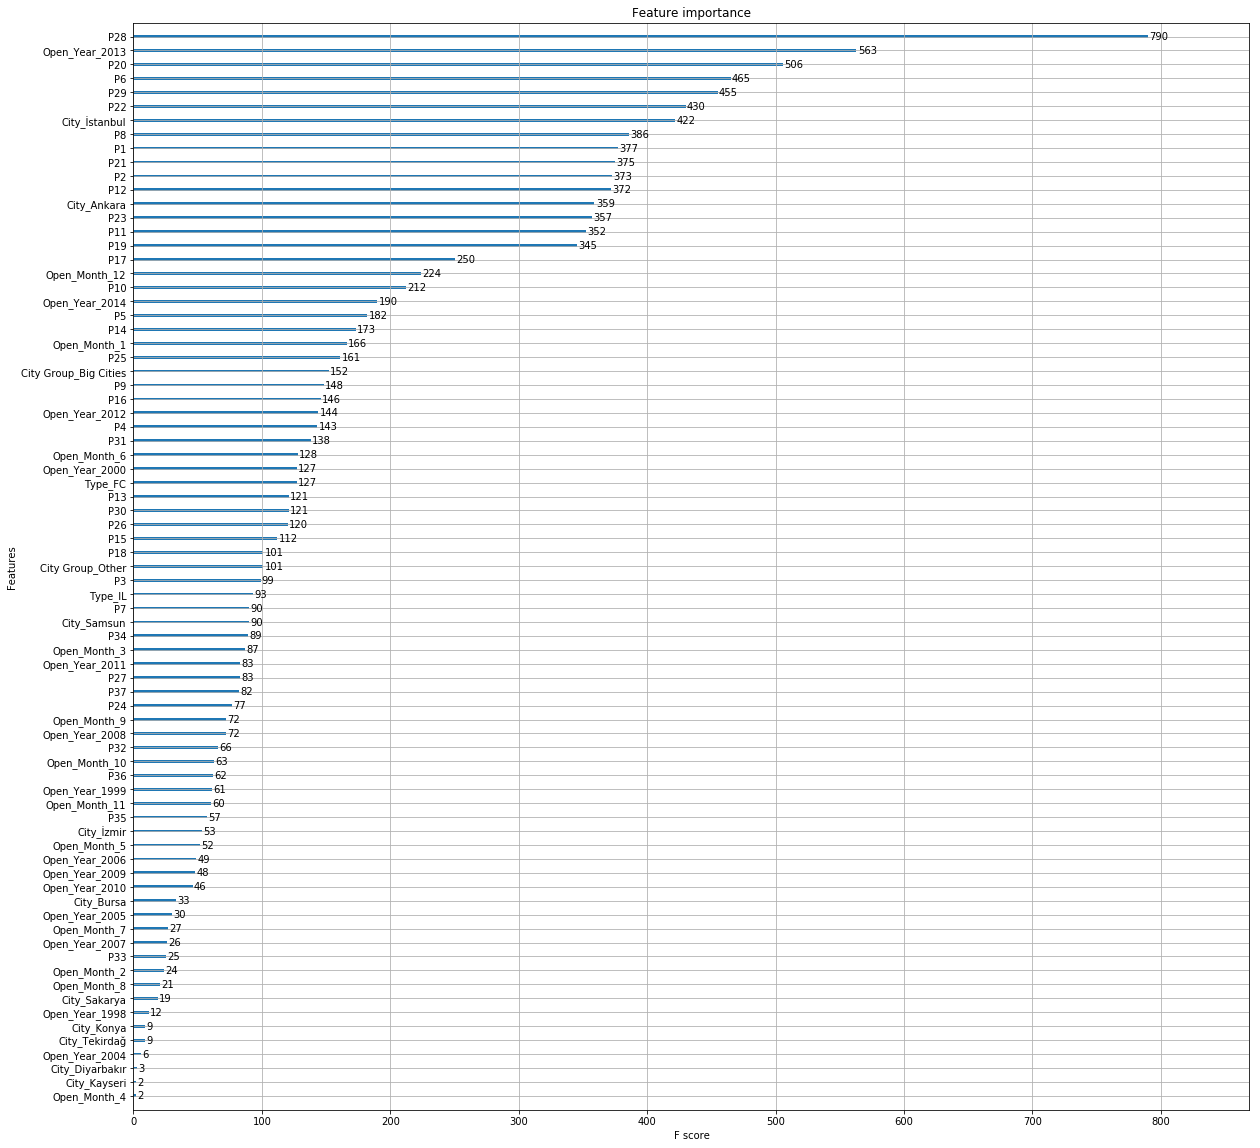

In [31]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xgbFinal, ax=ax)

# Prediction for Kaggle Submission

In [32]:
xgbFinal_submission = xgbFinal.predict(xgb.DMatrix(test_rf_x_drop))
xgbFinal_submission = np.square(np.exp(xgbFinal_submission))

In [ ]:
## Other submission style
## Creating a Submission File to submit to Kaggle competition ##
testData = pd.read_csv("test.csv")
submission = pd.DataFrame({
        "Id": testData["Id"],
        "Prediction": xgbFinal_submission
    })
submission.to_csv('XGboost_full_model_drop_features_sqrt_log_y_The_best_TRY1_trial.csv',header=True, index=False)

# Saving the final model

In [ ]:
pickle.dump(xgbFinal, open("xgbFinal_THE_BEST_MODEL.pickle.dat", "wb"))

# Loading the final model

In [ ]:
xgb_test = pickle.load(open("xgbFinal_THE_BEST_MODEL.pickle.dat", "rb"))

In [ ]:
# Re-forecast the prediction to verify the model
xgb_test_pred = xgb_test.predict(xgb.DMatrix(test_rf_x_drop))
xgb_test_pred = np.square(np.exp(xgb_test_pred))

In [ ]:
verify_model = (xgbFinal_submission == xgb_test_pred)
verify_model.sum()